# Ontology closest category evaluation

In [1]:
from graphai.core.common.ontology_utils.data import OntologyData
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [17]:
ontology_data = OntologyData(test_mode=True, test_ratio=0.2, random_state=10)
ontology_data.load_data()

1497301 1497301 1497301


Let's see the size of the test and training sets:

In [18]:
print(ontology_data.get_test_category_concept().shape[0], ontology_data.get_category_concept_table().shape[0])

3947 15792


In [19]:
test_category_concept = ontology_data.get_test_category_concept()
test_concepts = test_category_concept['to_id'].values.tolist()
test_labels = test_category_concept['from_id'].values.tolist()

In [20]:
def predict_all(model: OntologyData, x: list, avg='linear', coeffs=(1, 4), top_down=True, n=5):
    y = list()
    for p in x:
        best_cats, best_scores, selected_d3_category, best_clusters = \
            model.get_concept_closest_category(p, avg=avg, coeffs=coeffs, top_n=n, use_depth_3=top_down,
                                               return_clusters=None)
        if best_cats is None:
            best_cats = list()
        y.append(best_cats)
    return y

def eval_at_k(res, labels, k):
    max_k = max([len(x) for x in res])
    if k > max_k:
        print('Maximum n is %d, cannot return evaluation metrics @ %d' % (max_k, k))
        return None
    results_to_evaluate = [set(x[:k]) for x in res]
    n_correct = sum([1 if labels[i] in results_to_evaluate[i] else 0 for i in range(len(results_to_evaluate))])
    n_total = len(labels)
    acc = n_correct / n_total
    return acc

def get_max_accuracy(res):
    return len([x for x in res if len(x) > 0]) / len(res)
    

## Evaluating different combinations

In [21]:
parameter_list = list(
    itertools.product(['log', 'linear'], [(1, 1), (10, 1), (1, 10), (1, 100), (0, 1)],
                      [False, True])
)

In [22]:
all_results = [
    predict_all(ontology_data, test_concepts, avg=params[0], coeffs=params[1], top_down=params[2], n=10)
    for params in parameter_list
]

In [23]:
all_eval_at_1 = [eval_at_k(results, test_labels, 1) for results in all_results]

In [24]:
all_eval_at_5 = [eval_at_k(results, test_labels, 5) for results in all_results]

In [25]:
all_eval_at_10 = [eval_at_k(results, test_labels, 10) for results in all_results]

In [26]:
all_max_acc = [get_max_accuracy(results) for results in all_results]

### Results

#### Accuracy @ 1

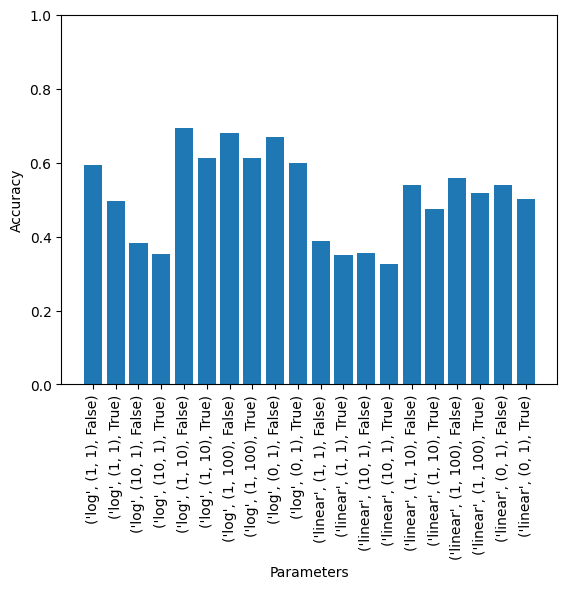

In [27]:
plt.bar([str(x) for x in parameter_list], height=all_eval_at_1)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Parameters')
plt.ylim([0, 1])
plt.show()

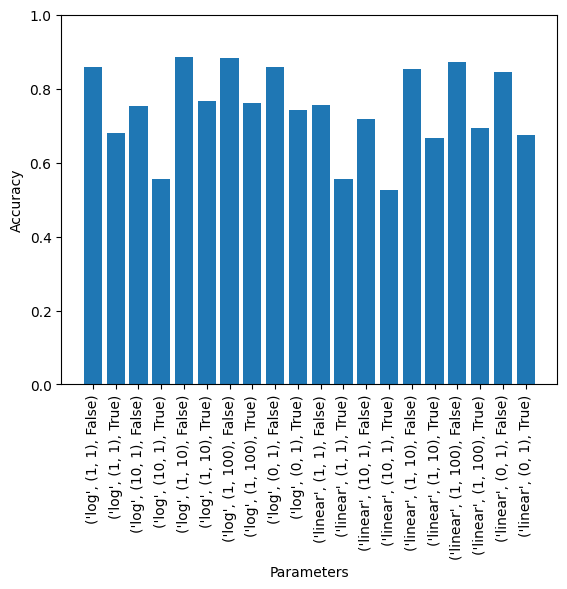

In [28]:
plt.bar([str(x) for x in parameter_list], height=all_eval_at_5)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Parameters')
plt.ylim([0, 1])
plt.show()

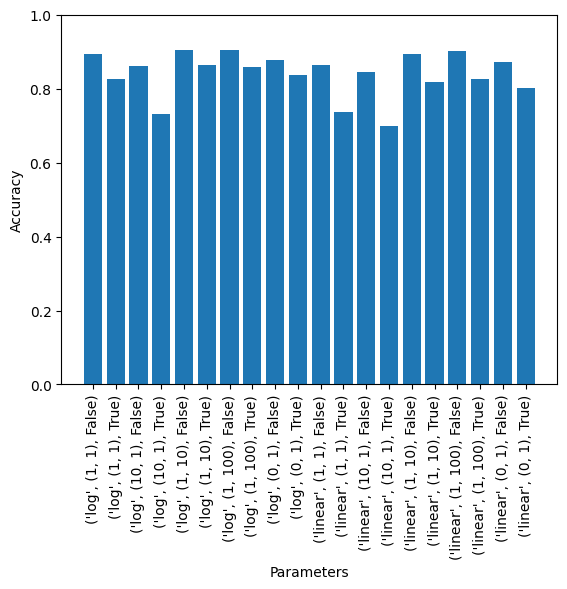

In [29]:
plt.bar([str(x) for x in parameter_list], height=all_eval_at_10)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Parameters')
plt.ylim([0, 1])
plt.show()

Let's see the results for the best parameters:

Best params:

In [30]:
parameter_list[np.argmax(all_eval_at_1)]

('log', (1, 10), False)

Accuracy @1, @5 and @10:

In [31]:
all_eval_at_1[np.argmax(all_eval_at_1)], all_eval_at_5[np.argmax(all_eval_at_1)], all_eval_at_10[np.argmax(all_eval_at_1)]

(0.6929313402584241, 0.885482645046871, 0.9062579174056246)

What are the conclusions that we can draw here?
* log >>>>>>> linear
* Top-down search always makes the results worse
* Concepts are much more important than anchors, but anchor pages are useful after all and removing them or de-emphasizing them too much reduces accuracy.